## Get distances to POIs along road network

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [59]:
import logging

import sys

sys.path.append("/app")

# import scraping as sc

import pandas as pd

from jinja2 import Template

from db_utils import get_engine, get_table_creation_query

from gis_utils import get_gdf_coords, get_closest_idxs, get_closest_pois_slow


import dataloader as loader


import numpy as np
import os

import geopandas as gpd
from network_utils import get_closest_osmids
from constants import DATA_PATH
import pickle
import osmnx as ox
import networkx as nx

<IPython.core.display.Javascript object>

In [54]:
# global logger
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s [%(name)s] %(levelname)-8s %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

<IPython.core.display.Javascript object>

## Connect to Database

In [3]:
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")

<IPython.core.display.Javascript object>

In [4]:
engine = get_engine(user, password, host)

<IPython.core.display.Javascript object>

## Define search parameters

In [5]:
searchname = "tamzin"

<IPython.core.display.Javascript object>

## Load Data

In [92]:
with engine.connect() as conn:
    df_closest_pois = pd.read_sql(
        f"""
    SELECT c.eastings,c.northings,c.poi_id,c.address_id,c.poi_category FROM {searchname}.closest_pois c
    INNER JOIN {searchname}.address_ids_to_process a
    ON c.address_id=a.address_id""",
        con=conn,
    )
    df_addressnodes = pd.read_sql(
        f"""
    SELECT n.* FROM {searchname}.address_nodes n
    INNER JOIN {searchname}.address_ids_to_process a
    ON n.address_id=a.address_id""",
        con=conn,
    )
    df_poinodes = pd.read_sql("SELECT * FROM poi_nodes", con=conn)
    df_nodes = pd.read_sql("SELECT * FROM node_coords", con=conn)

<IPython.core.display.Javascript object>

In [82]:
logger.info("Attempting to load network...")
try:
    with open(os.path.join(DATA_PATH, "roadnet_greaterlondon_walking.pkl"), "rb") as f:
        walknet = pickle.load(f)
        logger.info("Loaded network")
except EOFError as e:
    logger.warning("unable to load from pickle. Loading from graphml")
    walknet = ox.load_graphml(
        os.path.join(DATA_PATH, "roadnet_greaterlondon_walking.graphml")
    )
    logger.info("saving new network")
    with open(os.path.join(DATA_PATH, "roadnet_greaterlondon_walking.pkl"), "wb") as f:
        walknet = pickle.dump(walknet, f)
    logger.info("saved new network as pickle")

2021-05-21 20:16:33,389 [root] INFO     Attempting to load network...
2021-05-21 20:16:53,116 [root] INFO     Loaded network


<IPython.core.display.Javascript object>

In [93]:
df_closest_pois = df_closest_pois.join(
    df_addressnodes.set_index("address_id")[["osmid"]].rename(
        columns={"osmid": "osmid_address"}
    ),
    on="address_id",
)

<IPython.core.display.Javascript object>

In [94]:
df_points = df_closest_pois.join(
    df_poinodes.set_index(["poi_id", "poi_category"])[["osmid"]].rename(
        columns={"osmid": "osmid_poi"}
    ),
    on=["poi_id", "poi_category"],
    how="inner",
)

<IPython.core.display.Javascript object>

In [95]:
df_points["shortest_path_distance"] = df_points.apply(
    lambda x: nx.shortest_path_length(
        walknet, x.osmid_address, x.osmid_poi, weight="length"
    ),
    axis=1,
)

<IPython.core.display.Javascript object>

In [96]:
import seaborn as sns

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='shortest_path_distance', ylabel='Density'>

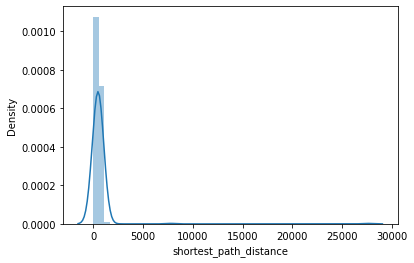

<IPython.core.display.Javascript object>

In [97]:
sns.distplot(df_points.shortest_path_distance)

In [98]:
df_points

,eastings,northings,poi_id,address_id,poi_category,osmid_address,osmid_poi,shortest_path_distance
0,NaN,NaN,438,1,station,3625978674,391661406,704.564
15,NaN,NaN,438,8,station,26373735,391661406,587.430
18,NaN,NaN,438,9,station,26373735,391661406,587.430
24,NaN,NaN,438,12,station,33043191,391661406,433.431
27,NaN,NaN,438,13,station,856374252,391661406,453.711
...,...,...,...,...,...,...,...,...
202,NaN,NaN,380,92,tube,26788876,7778679863,545.446
306,NaN,NaN,421,128,station,5473525786,5473525786,0.000
307,NaN,NaN,421,128,tube,5473525786,5473525786,0.000
327,NaN,NaN,268,135,station,8586229072,1930497010,27508.798


<IPython.core.display.Javascript object>

## Polygons

In [99]:
df_polygons = df_closest_pois[
    ~df_closest_pois.poi_category.isin(df_points.poi_category.unique())
]

<IPython.core.display.Javascript object>

In [100]:
coords_nodes = df_nodes[["eastings", "northings"]].values

<IPython.core.display.Javascript object>

In [101]:
closest_osmids_poly = get_closest_osmids(
    df_polygons[["eastings", "northings"]].values,
    coords_nodes,
    df_nodes.osmid.values,
)

<IPython.core.display.Javascript object>

In [103]:
df_polygons["osmid_poi"] = closest_osmids_poly

<ipython-input-103-64309221bd45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polygons["osmid_poi"] = closest_osmids_poly


<IPython.core.display.Javascript object>

In [105]:
df_polygons["shortest_path_distance"] = df_polygons.apply(
    lambda x: nx.shortest_path_length(
        walknet, x.osmid_address, x.osmid_poi, weight="length"
    ),
    axis=1,
)

<ipython-input-105-1d9edc5de5dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polygons["shortest_path_distance"] = df_polygons.apply(


<IPython.core.display.Javascript object>

## Combine

In [108]:
df_comb = df_points.append(df_polygons, ignore_index=True)

<IPython.core.display.Javascript object>

## Save

In [111]:
cols = {
    "poi_id": "INTEGER",
    "address_id": "INTEGER",
    "poi_category": "VARCHAR(64)",
    "distance": "DECIMAL(10,3)",
}

index_cols = ["poi_id", "address_id", "poi_category"]
unique_cols = []

<IPython.core.display.Javascript object>

In [112]:
create_q = get_table_creation_query(
    "poi_distances", cols, searchname, index_cols, unique_cols
)

<IPython.core.display.Javascript object>

In [114]:
with engine.connect() as conn:
    conn.execute(create_q)

<IPython.core.display.Javascript object>

In [116]:
with engine.connect() as conn:
    df_comb[["address_id", "poi_category", "shortest_path_distance"]].rename(
        columns={"shortest_path_distance": "distance"}
    ).to_sql(
        "poi_distances", schema=searchname, index=False, con=conn, if_exists="append"
    )

<IPython.core.display.Javascript object>